In [1]:
import numpy as np
import datetime

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

2024-04-29 16:26:11.882219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Estilos

In [2]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

font_leg = {'family' : 'DejaVu Sans',
            'weight' : 'bold',
            'size'   : 10}

## <center><h2>Elementos de una red neuronal</h2></center>

Ya se ha visto la estructura básica de una red neuronal. Vimos que una neurona realiza una suma ponderada y sobre esta aplica una función de activación que será el valor de salida de la neurona, luego, una vez se han obtenido las predicciones de la red para los datos de entrenamiento, se puede calcular la función de costo que será el objetivo a minimizar por medio del ajuste de los pesos en cada época del entrenamiento. Este ajuste se realiza por medio de algún algoritmo de minimización y, en esencia, todos hacen uso del gradiente de la función de costo. Para calcular este gradiente se debe utilizar un algoritmo muy especial conocido como *El Algoritmo de Backpropagation*. En este notebook se analizarán en mayor detalle cada una de estas componentes del proceso de entrenamiento de la red neuronal. 

## Funciones de activación

Una neurona tendrá un determinado número de entradas $x_i$, cada una de ellas un escalar, e internamente realizará una suma ponderada $z=\sum w_ix_i+b$ de estas, luego la suma es entregada a una función de activación $a(z)$ y este será el valor de salida de la neurona. 

Por ejemplo, en el caso del perceptrón propuesto por [Frank Rosenblatt](https://es.wikipedia.org/wiki/Perceptr%C3%B3n), la función de activación es la función escalón unitario, pero tenemos gran variedad de funciones de activación, por ejemplo, keras nos ofrece las siguientes:

<p><center>relu, sigmoid, softmax, softplus, softsign, tanh, selu, elu, exponential, leaky_relu, relu6, silu, hard_silu, gelu, hard_sigmoid, linear, mish, log_softmax.</center></p>

aunque también nos permite definir las nuestras propias. El objetivo de una función de activación es lograr activar las neuronas de modo que la red completa logre aprender. No tener una función de activación en una red, por más grande que sea, hará que toda la red se comporte como si tuviésemos una sola capa. Consideremos la primera capa con función de activación $a^{[1]}(z)$, denotemos por $z^{[1]}$ las sumas ponderadas para cada neurona de la primera capa: 

\begin{equation}
z^{[1]} = w^{[1]}x^{[1]}+b^{[1]} \nonumber
\end{equation}

con $x^{[1]}$ la entrada a la capa $1$. Para la segunda capa sus entradas serían las salidas de la primera capa, es decir $a^{[1]}(z^{[1]})$. No tener función de activación es lo mismo que usar $a(z)=z$, así, para la segunda capa tendríamos que su salida sería:

\begin{eqnarray}
a^{[2]}(z^{[2]}) &=& z^{[2]}\\
                 &=& w^{[2]}x^{[2]}+b^{[2]}\nonumber \\
                 &=& w^{[2]}a^{[1]}+b^{[2]}\nonumber  \\
                 &=& w^{[2]}z^{[1]}+b^{[2]}\nonumber  \\
                 &=& w^{[2]}[w^{[1]}x^{[1]}+b^{[1]}]+b^{[2]}\nonumber \\
                 &=& w^{[2]}w^{[1]}x^{[1]} + w^{[2]}b^{[1]} +b^{[2]}\nonumber  \\ 
\end{eqnarray}

definiendo $w^{[2]}w^{[1]}=w'$ y $w^{[2]}b^{[1]} +b^{[2]}=b'$ obtenemos

\begin{equation}
a^{[2]}(z^{[2]}) = w'x^{[1]}+b' \nonumber 
\end{equation}

De esta expresión concluimos que la ausencia de una función de activación acabará por hacer que toda la red colapse a una sola capa lineal por lo que no se produce aprendizaje durante el entrenamiento sin importar cuantas capas se utilicen. 

A continuación vamos a comenzar por analizar algunas de las funciones de activación más relevantes y su derivada pues esta es también de alta importancia para poder entender su uso. 

### Lineal
La función de activación más simple sería la función de activación lineal que es una función identidad que, como acabamos de ver, no permite que se produzca aprendizaje en las capas internas de la red.

Veamos su representación gráfica y la de su derivada. Pero antes, como estaremos graficando varias funciones de activación minimicemos código generando una función que haga esto.

In [3]:
def plot_af(x,
            af,
            daf,
            af_ylabel,
            daf_ylabel):
    
    # gráfico
    fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

    ax[0].plot(x, af(x), color="k", lw=2)
    ax[0].set_title("AF", **font)
    ax[0].set_ylabel(af_ylabel, **font)
    ax[0].set_xlim(min(x), max(x))

    ax[1].plot(x, daf(x), color="red", lw=2)
    ax[1].set_title("Derivative of the AF", **font)
    ax[1].set_ylabel(daf_ylabel, **font)
    ax[1].set_xlim(min(x), max(x))

    plt.tight_layout()

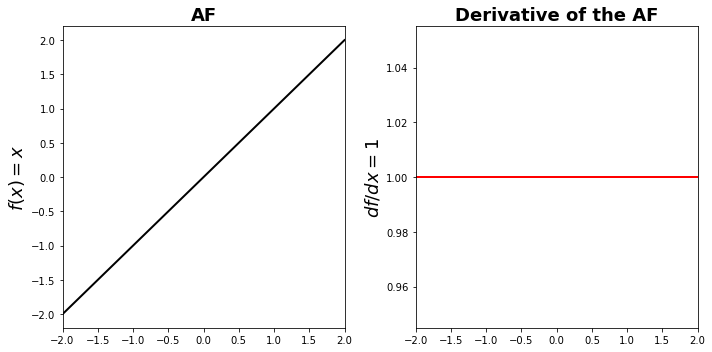

In [4]:
# derivada
x = np.linspace(-2, 2, 100)

def d_lineal(x):
    return 1
d_lineal = np.vectorize(d_lineal)

plot_af(x,
        af=keras.activations.linear,
        daf=d_lineal,
        af_ylabel=f"$f(x)=x$",
        daf_ylabel=f"$df/dx=1$")


Aparte de lo que ya se ha dicho hasta este momento, hay una característica importante que se puede resaltar sobre la función identidad, y es que su derivada es constante, es decir siempre tiene el mismo valor, $1$. Este hecho permite que se pueda producir una actualización constante de los pesos pues, como se verá cuando analicemos el algoritmo de backpropagation, una de las condiciones que tienen que cumplir las funciones de activación es que su derivada no puede ser nula en todos los puntos de su dominio. La derivada de la función de activación es determinante a la hora de entrenar un modelo pues determinará la rapidez con la cual este aprende. 

In [5]:
# Algunos datos de prueba
np.random.seed(0)
xp = np.random.uniform(-10, 10, 10)
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [6]:
keras.activations.linear(xp)

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

Generemos ahora un modelo con múltiples capas para probar el aprendizaje de una red neuronal. 

In [9]:
def create_model(name,
                 shape,
                 units=[80, 90, 80, 80],
                 af="relu",
                 output_af="softmax"):
    
    layers = 4
    if type(units)==int:
        units=[units]*layers
    if type(af)==str:
        af=[af]*layers
        
    model = keras.Sequential(name=name)
    model.add(keras.Input(shape=shape))
    model.add(keras.layers.Flatten(name="Flatten"))
    model.add(keras.layers.Dense(units=units[0], activation=af[0], name="layer_1"))
    model.add(keras.layers.Dense(units=units[1], activation=af[1], name="layer_2"))
    model.add(keras.layers.Dense(units=units[2], activation=af[2], name="layer_3"))
    model.add(keras.layers.Dense(units=units[3], activation=af[3], name="layer_4"))
    model.add(keras.layers.Dense(units=len(class_names), activation=output_af, name="output"))
    
    return model

#### Datos

In [8]:
# carga
fm = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fm.load_data()

# normalización
train_images, test_images = train_images/255., test_images/255.

# clases
class_names = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
)

for i, label in enumerate(class_names):
    print(f"{i} --> {label}")
    
train_images.shape, test_images.shape

0 --> T-shirt/top
1 --> Trouser
2 --> Pullover
3 --> Dress
4 --> Coat
5 --> Sandal
6 --> Shirt
7 --> Sneaker
8 --> Bag
9 --> Ankle boot


((60000, 28, 28), (10000, 28, 28))

In [10]:
# modelo
model_fm_linear = create_model(name="fashionmn_af_linear", 
                               shape=train_images[0].shape, 
                               af="linear",
                               output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_linear.compile(optimizer=opt,
                        loss=loss, metrics=["accuracy"])

model_fm_linear.summary()

2024-04-29 16:28:48.356005: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "fashionmn_af_linear"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_linear = model_fm_linear.fit(train_images,
                                        train_labels,
                                        validation_split=0.2,
                                        epochs=10)

history_fm_linear = history_fm_linear.history

# medimos el tiempo de ejecución
time_fm_linear = datetime.datetime.now() - start
print(f"\nTime to run using linear: {time_fm_linear}")

2024-04-29 16:29:00.303548: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


Epoch 1/10
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7546 - loss: 0.6914

2024-04-29 16:29:09.018450: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37632000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7548 - loss: 0.6908 - val_accuracy: 0.8131 - val_loss: 0.5265
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8291 - loss: 0.4898 - val_accuracy: 0.8206 - val_loss: 0.5156
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8323 - loss: 0.4706 - val_accuracy: 0.8447 - val_loss: 0.4494
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8418 - loss: 0.4533 - val_accuracy: 0.8432 - val_loss: 0.4490
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8429 - loss: 0.4461 - val_accuracy: 0.8424 - val_loss: 0.4483
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8489 - loss: 0.4408 - val_accuracy: 0.8466 - val_loss: 0.4450
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8468 - loss: 0.4332 - val_accuracy: 0.8332 - val_loss: 0.4842
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8485 - loss: 0.4357 - val_accurac

Lo primero que podemos observar del uso de la función de activación lineal es que las métricas del modelo y su función de costo no mejoran en cada época, contrario a esto parecen oscilar al rededor de un valor promedio. Esto nos muestra de entrada que la elección de esta función de activación para todas las capas no es una buena elección, algo que irémos confirmando a medida que veamos la aplicación de otras funciones de activación. Se debe esperar que el valor de las métricas y la función de costo mejoren en cada época, este no es el caso.

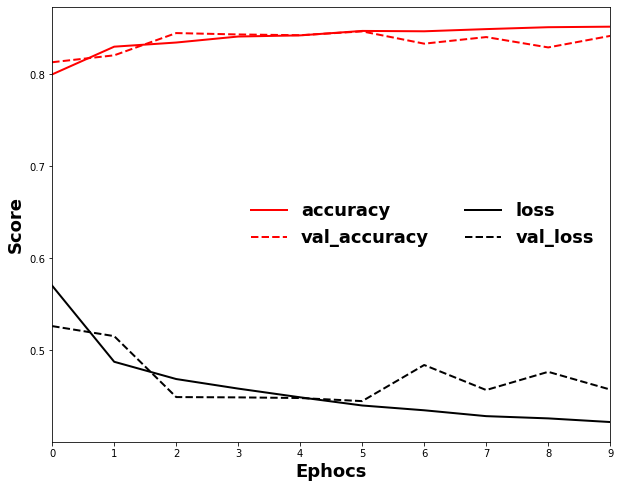

In [12]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(history_fm_linear["accuracy"],     color="red",   ls="-",  lw=2, label=list(history_fm_linear.keys())[0])
ax.plot(history_fm_linear["val_accuracy"], color="red",   ls="--", lw=2, label=list(history_fm_linear.keys())[2])
ax.plot(history_fm_linear["loss"],         color="black", ls="-",  lw=2, label=list(history_fm_linear.keys())[1])
ax.plot(history_fm_linear["val_loss"],     color="black", ls="--", lw=2, label=list(history_fm_linear.keys())[3])

ax.set_xlim(0, len(history_fm_linear["accuracy"])-1)
ax.set_xlabel("Ephocs", **font)
ax.set_ylabel("Score", **font)

ax.legend(prop=font, ncol=2, frameon=False)
plt.show()

Como decíamos, las métricas y función de costo varían muy poco en cada iteración, este comportamiento se hará más evidente cuando veamos las otras funciones de activación.

Veamos ahora la capacidad de predicción de este modelo.

In [13]:
# Métricas de testeo
model_fm_linear.evaluate(x=test_images, y=test_labels)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.8438 - loss: 0.4265

2024-04-29 16:29:54.236905: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8388 - loss: 0.4748


[0.49085113406181335, 0.8317999839782715]

In [14]:
# Métricas de entrenamiento
model_fm_linear.evaluate(x=train_images, y=train_labels)

  80/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8493 - loss: 0.4204

2024-04-29 16:29:55.839328: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8494 - loss: 0.4235


[0.42988890409469604, 0.8483999967575073]

### ReLU

[ReLU](https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)) es una de las funciones de activación más utilizadas para capas ocultas en la actualidad por sus excelentes características a la hora de entrenar. Está definida por

\begin{eqnarray}
    \text{ReLU}(x) = \text{max}(0,x)
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ReLU}}{dx} = \left\{ \begin{array}{lcc} 
                                                      0 & si & x \leq 0 \\
                                                      1 & si & x > 0     \\
                                   \end{array}
                           \right.
\end{equation}

graficamente tenemos

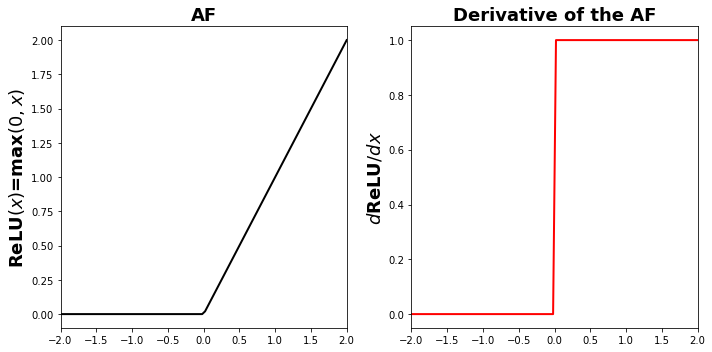

In [15]:
# derivada
x = np.linspace(-2, 2, 100)

def d_relu(x):
    if x<=0:
        return 0
    return 1

d_relu = np.vectorize(d_relu)

plot_af(x,
        af=keras.activations.relu,
        daf=d_relu,
        af_ylabel=f"ReLU$(x)$=max$(0,x)$",
        daf_ylabel=f"$d$ReLU$/dx$")


Otras funciones de activación como *tanh* y *sofmax* tienen derivadas que en los extremos tienden a ser nulas y esto genera el conocido como *desvanecimiento del gradiente* que estudiaremos más adelante. La función ReLU, por otro lado, tiene una derivada constante para valores positivos, además de ser una función muy sencilla de calcular comparada con funciones como *tanh* y *sofmax*. Estas características hacen de ella una función de activación altamente utilizada ya que puede acelerar el proceso de aprendizaje de la red. Otro atributo relevante es que genera esparsidad en la red al apagar algunas neuronas (su derivada es cero para valores menores a cero) conduciendo así a una reducción indirecta del overfitting. 

Veamos su comportamiento con algunos datos:

In [16]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [17]:
keras.activations.relu(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.97627008, 4.30378733, 2.05526752, 0.89766366, 0.        ,
       2.91788226, 0.        , 7.83546002, 9.27325521, 0.        ])>

Ahora entrenemos un modelo con la misma aquitectura que el modelo anterior pero utilizaremos una función de activación RelU en las capas ocultas. 

In [18]:
# modelo
model_fm_relu = create_model(name="fashionmn_af_relu", 
                               shape=train_images[0].shape, 
                               af="relu",
                               output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_relu.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_relu.summary()

Model: "fashionmn_af_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_relu = model_fm_relu.fit(train_images,
                                    train_labels,
                                    validation_split=0.2,
                                    epochs=10)

history_fm_relu = history_fm_relu.history
# medimos el tiempo de ejecución
time_fm_relu = datetime.datetime.now() - start
print(f"\nTime to run using relu: {time_fm_relu}")

Epoch 1/10


2024-04-29 16:31:15.291091: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7368 - loss: 0.7339 - val_accuracy: 0.8396 - val_loss: 0.4384
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8579 - loss: 0.3890 - val_accuracy: 0.8565 - val_loss: 0.3936
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8698 - loss: 0.3512 - val_accuracy: 0.8666 - val_loss: 0.3759
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8802 - loss: 0.3305 - val_accuracy: 0.8767 - val_loss: 0.3417
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8844 - loss: 0.3097 - val_accuracy: 0.8777 - val_loss: 0.3278
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8896 - loss: 0.2979 - val_accuracy: 0.8783 - val_loss: 0.3389
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8947 - loss: 0.2858 - val_accuracy: 0.8662 - val_loss: 0.3843
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8997 - loss: 0.2663 - val_accurac

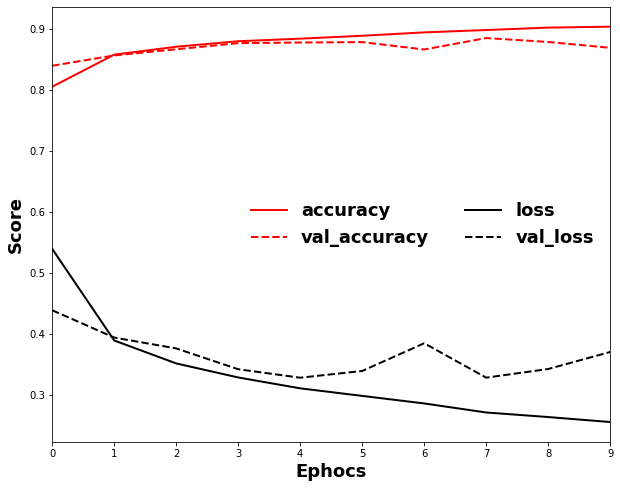

In [20]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(history_fm_relu["accuracy"],     color="red",   ls="-",  lw=2, label=list(history_fm_relu.keys())[0])
ax.plot(history_fm_relu["val_accuracy"], color="red",   ls="--", lw=2, label=list(history_fm_relu.keys())[2])
ax.plot(history_fm_relu["loss"],         color="black", ls="-",  lw=2, label=list(history_fm_relu.keys())[1])
ax.plot(history_fm_relu["val_loss"],     color="black", ls="--", lw=2, label=list(history_fm_relu.keys())[3])

ax.set_xlim(0, len(history_fm_relu["accuracy"])-1)
ax.set_xlabel("Ephocs", **font)
ax.set_ylabel("Score", **font)

ax.legend(prop=font, ncol=2, frameon=False)
plt.show()

En esta ocasión vemos que tanto las métricas como la función de perdida mejoran en cada iteración, contrario a cuando utilizamos la función de activación lineal. 

In [21]:
# Métricas de testeo
model_fm_relu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8563 - loss: 0.4038


[0.40560272336006165, 0.8575999736785889]

In [22]:
# Métricas de entrenamiento
model_fm_relu.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8895 - loss: 0.2877


[0.30376285314559937, 0.8862333297729492]

### tanh

La función tangente hiperbólica está definida a partir del uso de funciones exponenciales:

\begin{eqnarray}
    \text{tanh}(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{tanh}}{dx} = 1- \text{tanh}^2(x)
\end{equation}

graficamente tenemos


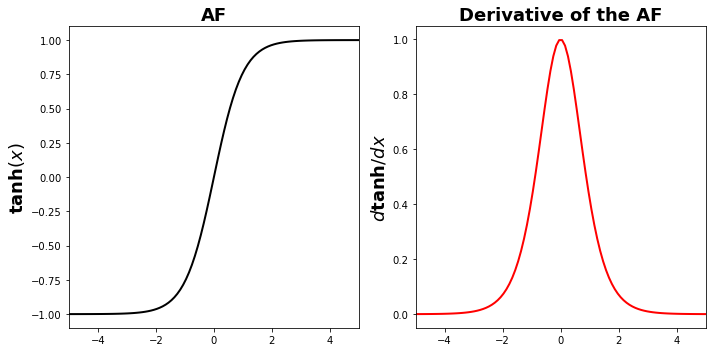

In [24]:
# derivada
x = np.linspace(-5, 5, 100)

def d_tanh(x):
    return 1 - np.tanh(x)**2

d_tanh = np.vectorize(d_tanh)

plot_af(x,
        af=keras.activations.tanh,
        daf=d_tanh,
        af_ylabel=f"tanh$(x)$",
        daf_ylabel=f"$d$tanh$/dx$")

## Funciones de perdida

## Optimizadores

## Algoritmo de Backpropagation